In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# System libraries
from pathlib import Path
import os

# Metrics
sns.set_style('darkgrid')

In [ ]:
# Step 1: Authenticate and Upload kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhabibr","key":"2115a0304f3b795016791757af3b3c9a"}'}

In [ ]:
# Step 2: Set up kaggle API and download dataset
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
 98% 74.0M/75.7M [00:00<00:00, 276MB/s]
100% 75.7M/75.7M [00:00<00:00, 256MB/s]


In [ ]:
# Step 3: Unzip the dataset
import zipfile
with zipfile.ZipFile('/content/potato-plant-diseases-data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
# Step 4: Define the path to the dataset
data_path = '/content/dataset/PlantVillage'

Found 2152 files belonging to 1 classes.
                                            Filepath             Label
0  /content/dataset/PlantVillage/PlantVillage/Pot...  Potato___healthy
1  /content/dataset/PlantVillage/PlantVillage/Pot...  Potato___healthy
2  /content/dataset/PlantVillage/PlantVillage/Pot...  Potato___healthy
3  /content/dataset/PlantVillage/PlantVillage/Pot...  Potato___healthy
4  /content/dataset/PlantVillage/PlantVillage/Pot...  Potato___healthy


<ipython-input-6-558f4a6d2d99>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='mako')


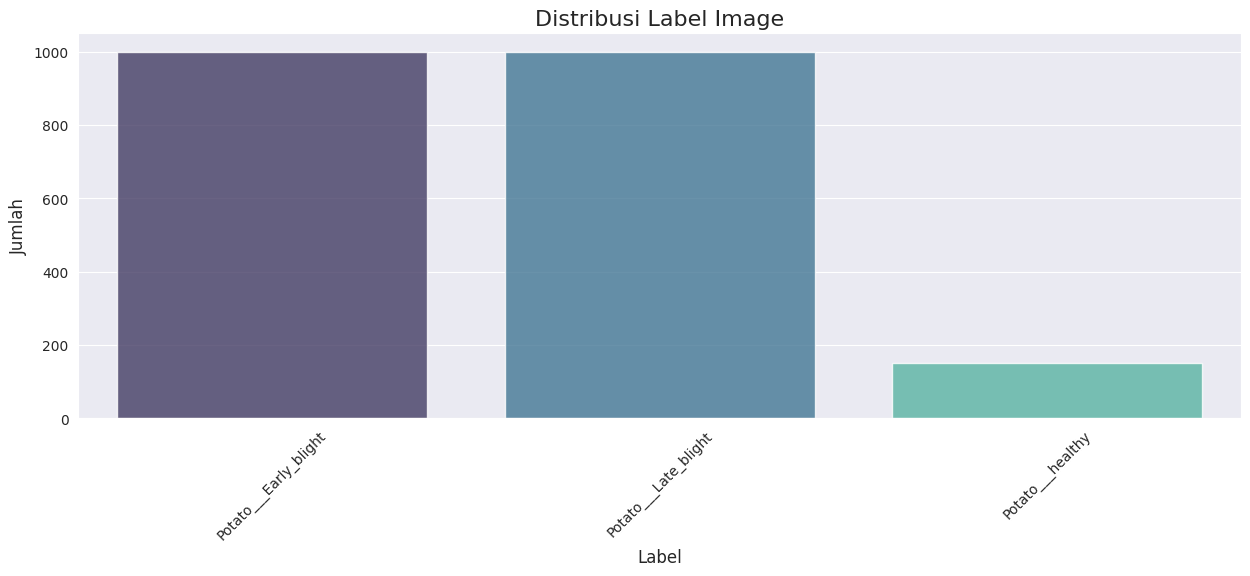

In [ ]:
# Step 5: Load dataset and create a DataFrame
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Load the dataset from the extracted directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Define the directory containing the images
image_dir = Path(data_path)

# Get filepaths for specific image file types
filepaths = list(image_dir.glob(r'**/*.JPG')) + \
            list(image_dir.glob(r'**/*.jpg')) + \
            list(image_dir.glob(r'**/*.png')) + \
            list(image_dir.glob(r'**/*.PNG'))

# Extract labels from filepaths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Convert filepaths and labels into Pandas Series
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels into a DataFrame
image_df = pd.concat([filepaths, labels], axis=1)

# Display the first few rows of the DataFrame
print(image_df.head())

# Visualize label distribution
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='mako')
plt.title('Distribusi Label Image', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Step 6: Install and setup YOLOv8
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 27.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Step 7: Prepare dataset for YOLOv8 with actual labels
import shutil
from tqdm import tqdm

# Create directories for YOLO format
yolo_base_dir = '/content/yolo_dataset'
os.makedirs(yolo_base_dir, exist_ok=True)

for split in ['train', 'val']:
    os.makedirs(os.path.join(yolo_base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolo_base_dir, split, 'labels'), exist_ok=True)

# Define class mapping for YOLO
class_mapping = {label: idx for idx, label in enumerate(label_counts.index)}

# Convert dataset to YOLO format with actual labels
for idx, row in tqdm(image_df.iterrows(), total=len(image_df)):
    label = row['Label']
    img_path = row['Filepath']
    class_id = class_mapping[label]

    # Split data (80% train, 20% val)
    split = 'train' if random.random() < 0.8 else 'val'
    shutil.copy(img_path, os.path.join(yolo_base_dir, split, 'images', os.path.basename(img_path)))

    # For now, use dummy bounding box (replace this with real bounding box data if available)
    # Get image dimensions to compute bounding box in YOLO format
    img = tf.image.decode_image(tf.io.read_file(img_path))
    img_height, img_width, _ = img.shape
    x_center = 0.5  # Replace with real bounding box center if available
    y_center = 0.5  # Replace with real bounding box center if available
    width = 1.0  # Replace with real bounding box width
    height = 1.0  # Replace with real bounding box height

    # Create label file with correct bounding box format
    label_path = os.path.join(yolo_base_dir, split, 'labels', os.path.splitext(os.path.basename(img_path))[0] + '.txt')
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Create dataset.yaml
classes = list(label_counts.index)
dataset_yaml = f"""
path: {yolo_base_dir}
train: train/images
val: val/images
nc: {len(classes)}
names: {classes}
"""
with open(os.path.join(yolo_base_dir, 'dataset.yaml'), 'w') as f:
    f.write(dataset_yaml)

100%|██████████| 2152/2152 [00:02<00:00, 764.50it/s]


In [ ]:
# Step 8: Train YOLOv8 model
model = YOLO('yolov8n.pt')
model.train(data=os.path.join(yolo_base_dir, 'dataset.yaml'), epochs=10, imgsz=640)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo_dataset/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning /content/yolo_dataset/train/labels... 2073 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2073/2073 [00:01<00:00, 1843.80it/s]


train: New cache created: /content/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_dataset/val/labels... 780 images, 0 backgrounds, 0 corrupt: 100%|██████████| 780/780 [00:01<00:00, 597.34it/s]


val: New cache created: /content/yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.32G     0.3034      1.918      1.118          9        640: 100%|██████████| 130/130 [00:45<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.62it/s]

                   all        780        780      0.814       0.81      0.948      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.19G     0.1046      0.891      0.949          9        640: 100%|██████████| 130/130 [00:41<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


                   all        780        780      0.983      0.988      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.19G    0.09994     0.5771     0.9366          9        640: 100%|██████████| 130/130 [00:40<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


                   all        780        780      0.986      0.978      0.991      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.18G    0.08686     0.4236     0.9337          9        640: 100%|██████████| 130/130 [00:39<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


                   all        780        780      0.951      0.972      0.994      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.18G    0.07453     0.3026     0.9279          9        640: 100%|██████████| 130/130 [00:40<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        780        780      0.984      0.989      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.18G    0.06805     0.2796     0.9151          9        640: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]

                   all        780        780      0.973       0.98      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.18G    0.05827     0.2104     0.9083          9        640: 100%|██████████| 130/130 [00:38<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]

                   all        780        780      0.971      0.978      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.18G    0.04781     0.1754     0.9127          9        640: 100%|██████████| 130/130 [00:41<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.43it/s]

                   all        780        780      0.992      0.998      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.18G     0.0397     0.1395     0.9071          9        640: 100%|██████████| 130/130 [00:41<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


                   all        780        780      0.996      0.995      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.18G    0.03195     0.1256     0.9028          9        640: 100%|██████████| 130/130 [00:39<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]

                   all        780        780      0.994      0.999      0.995      0.995



10 epochs completed in 0.141 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


                   all        780        780      0.994      0.999      0.995      0.995
 Potato___Early_blight        347        347          1      0.997      0.995      0.995
  Potato___Late_blight        366        366          1          1      0.995      0.995
      Potato___healthy         67         67      0.983          1      0.995      0.995
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78ffe2983f10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
# Step 9: Run predictions
results = model.predict(source=os.path.join(yolo_base_dir, 'val/images'), conf=0.5, save=True)


image 1/780 /content/yolo_dataset/val/images/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG: 640x640 1 Potato___Early_blight, 10.3ms
image 2/780 /content/yolo_dataset/val/images/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG: 640x640 1 Potato___Early_blight, 7.3ms
image 3/780 /content/yolo_dataset/val/images/01ad74ce-eb28-42c7-9204-778d17cfd45c___RS_LB 2669.JPG: 640x640 1 Potato___Late_blight, 7.3ms
image 4/780 /content/yolo_dataset/val/images/02212653-e92b-49aa-96b7-9497af51e502___RS_LB 3151.JPG: 640x640 1 Potato___Late_blight, 7.2ms
image 5/780 /content/yolo_dataset/val/images/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG: 640x640 1 Potato___Early_blight, 7.2ms
image 6/780 /content/yolo_dataset/val/images/025f3c76-6d6c-4dad-ba22-e3e72d084ef1___RS_LB 3105.JPG: 640x640 1 Potato___Late_blight, 7.2ms
image 7/780 /content/yolo_dataset/val/images/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG: 640x640 1 Potato___Early_blight, 7.2ms
image 8/

In [ ]:
# Step 10: Display detection results
from IPython.display import Image, display
result_images = list(Path('runs/detect/predict').glob('*.jpg'))
for img_path in result_images[:5]:
    display(Image(filename=img_path))